In [83]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score
import imodelsx

sys.path.append('../experiments/')
results = []

results_dir = '../results/test/cebab'
experiment_filename = 'experiments/distillation_tbm.py'

# load the results in to a pandas dataframe
r = imodelsx.process_results.get_results_df(results_dir)

#cols_varied = imodelsx.process_results.get_experiment_keys(
#    r, experiment_filename)

#print('experiment varied these params:', cols_varied)
#r = imodelsx.process_results.fill_missing_args_with_default(
#    r, experiment_filename)

# save results as csvs for backup
#r.to_csv('../results/csvs/distillation_cub.csv')

# get the breakdown of data in these groups
#r.groupby(cols_varied).size()

100%|██████████| 1/1 [00:00<00:00, 142.17it/s]


# Intervention - number of iterations to flip pred

In [122]:
def remove_dup(input_lst):
        res = []
        for x in input_lst:
            if x not in res:
                res.append(x)
        return res

def compute_n_group_edits_to_get_it_right(interv_groups, old_pred, impute_vals, label, model):    
    cnt = 1
    for group in interv_groups:
        old_pred.iloc[group] = impute_vals.iloc[group]
        
        counterfactual_pred = model.predict(old_pred.to_numpy().reshape(1, -1))

        if task_name == "agnews":
            if counterfactual_pred[0] == label:
                break
        else:
            if np.abs(counterfactual_pred[0] - label) < 0.5:
                break
        cnt += 1

    if cnt == len(interv_groups):
        cnt = float('inf')
    return cnt

In [120]:
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from os.path import join
import collections
import pandas as pd
import ast

#AGNews: {"0":"world", "1":"sports","2":"business","3":"sci/tech"}

saved_data_path = "tbm_gpt4"
task_name = "cebab"
teacher_type = "linear"

# load in trained model
model = joblib.load(f'../data/tbm_gpt4/human_annotation/{task_name}_{teacher_type}_model.pkl')

# load in wrongly pred test samples
data = pd.read_csv(f'../data/tbm_gpt4/human_annotation/{task_name}_{teacher_type}_wrong_preds.csv')
old_data = pd.read_csv(f'../data/tbm_gpt4/human_annotation/{task_name}_{teacher_type}_old_preds.csv')
corrected_wrong_data = data[data['Mismatch'] == 'Yes']
old_wrong_data = old_data[old_data['Mismatch'] == 'Yes']
wrong_data_idxs = data.index[data['Mismatch'] == 'Yes'].tolist()

# Load in interv groups
interv_df = pd.read_csv(f'../data/tbm_gpt4/human_annotation/{task_name}_{teacher_type}_interv_groups.csv')
adap_interv_g = interv_df['cti_adap_test'].iloc[wrong_data_idxs]
rand_interv_g = interv_df['cti_rand_test'].iloc[wrong_data_idxs]
l_interv_g = interv_df['cti_l_test'].iloc[wrong_data_idxs]

# Load in concepts
concept_file = join('../data/tbm_gpt4', "{}_{}".format(task_name, teacher_type), "{}_concepts.csv".format(task_name))
concept_df = pd.read_csv(concept_file)
concepts = remove_dup(concept_df['Concept Name'].to_list())

assert(len(old_wrong_data) == len(corrected_wrong_data))

In [ ]:
method_to_groups = {'adap': adap_interv_g, 'rand': rand_interv_g, 'linear': l_interv_g}
method_to_flip_pred_count = collections.defaultdict(list)

for method in method_to_groups.keys():
    for i in range(len(corrected_wrong_data)):
        groups = method_to_groups[method]
    
        interv_groups = ast.literal_eval(groups.iloc[i])
        old_pred = old_wrong_data.iloc[i][concepts]
        impute_vals = corrected_wrong_data.iloc[i][concepts]
        label = old_wrong_data.iloc[i]['label']
        
        cnt = compute_n_group_edits_to_get_it_right(interv_groups, old_pred, impute_vals, label, model)
        method_to_flip_pred_count[method].append(cnt)

method_to_flip_pred_count

In [ ]:
method_to_groups = {'adap': adap_interv_g, 'rand': rand_interv_g, 'linear': l_interv_g}
method_to_flip_pred_count = collections.defaultdict(list)

for method in method_to_groups.keys():
    for i in range(len(corrected_wrong_data)):
        groups = method_to_groups[method]
    
        interv_groups = ast.literal_eval(groups.iloc[i])
        old_pred = old_wrong_data.iloc[i][concepts]
        impute_vals = corrected_wrong_data.iloc[i][concepts]
        label = old_wrong_data.iloc[i]['label']
        
        cnt = compute_n_group_edits_to_get_it_right(interv_groups, old_pred, impute_vals, label, model)
        method_to_flip_pred_count[method].append(cnt)

method_to_flip_pred_count

In [177]:
# adap got right with one intervention while other couldn't get right [-1]
print('text:', old_wrong_data.iloc[-1]['text'])
print('='*10)
print('pred:', old_wrong_data.iloc[-1]['preds'])
print('='*10)
print('label:', old_wrong_data.iloc[-1]['label'])
print('='*10)
print('original concept:', old_wrong_data.iloc[-1][concepts])
print('='*10)
print('annotated concept:', corrected_wrong_data.iloc[-1][concepts])
print('='*10)
print('adap intervened on:', [concepts[i] for i in ast.literal_eval(adap_interv_g.iloc[-1])[0]])
print('='*10)
print('linear intervened on:', [concepts[i] for i in ast.literal_eval(l_interv_g.iloc[-1])[0]])
print('='*10)
print('random intervened on:', [concepts[i] for i in ast.literal_eval(rand_interv_g.iloc[-1])[0]])
print('='*10)

text: My dining experience was one of the best. The food and service was outstanding. Everyone was very friendly just could have turned down the volume of the music a little.
pred: 4.581105186
label: 4
original concept: Service Quality               2
Food Quality                  2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          5
Music Experience             -1
Waiting Time                  0
Customer Expectations       1.0
Food Temperature              0
Restaurant Crowd              2
Presentation of Food          0
Restaurant Cleanliness        0
Meal Variety                  0
Name: 15, dtype: object
annotated concept: Service Quality               2
Food Quality                  2
Price Perception              0
Ambiance                      1
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
O

In [178]:
# all got right with one intervention [-2]
print('text:', old_wrong_data.iloc[-2]['text'])
print('='*10)
print('pred:', old_wrong_data.iloc[-2]['preds'])
print('='*10)
print('label:', old_wrong_data.iloc[-2]['label'])
print('='*10)
print('original concept:', old_wrong_data.iloc[-2][concepts])
print('='*10)
print('annotated concept:', corrected_wrong_data.iloc[-2][concepts])
print('='*10)
print('adap intervened on:', [concepts[i] for i in ast.literal_eval(adap_interv_g.iloc[-2])[0]])
print('='*10)
print('linear intervened on:', [concepts[i] for i in ast.literal_eval(l_interv_g.iloc[-2])[0]])
print('='*10)
print('random intervened on:', [concepts[i] for i in ast.literal_eval(rand_interv_g.iloc[-2])[0]])
print('='*10)

text: The food was excellent but the service was not.
pred: 2.388462503
label: 3
original concept: Service Quality              -2
Food Quality                  2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          2
Music Experience              0
Waiting Time                  0
Customer Expectations      -1.0
Food Temperature              0
Restaurant Crowd              2
Presentation of Food          0
Restaurant Cleanliness        0
Meal Variety                  0
Name: 14, dtype: object
annotated concept: Service Quality              -2
Food Quality                  2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          3
Music Experience              0
Waiting Time                  0
Customer Expectations     

In [173]:
# none got right [0, 2, 3]
print('text:', old_wrong_data.iloc[0]['text'])
print('='*10)
print('original concept:', old_wrong_data.iloc[0][concepts])
print('='*10)
print('annotated concept:', corrected_wrong_data.iloc[0][concepts])
print('='*10)
print('adap intervened on:', [concepts[i] for i in ast.literal_eval(adap_interv_g.iloc[0])[0]])
print('='*10)
print('linear intervened on:', [concepts[i] for i in ast.literal_eval(l_interv_g.iloc[0])[0]])
print('='*10)
print('random intervened on:', [concepts[i] for i in ast.literal_eval(rand_interv_g.iloc[0])[0]])
print('='*10)

text: Portions were very small and all the food was very overcooked.
original concept: Service Quality              -1
Food Quality                 -2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          2
Music Experience              0
Waiting Time                  0
Customer Expectations      -1.0
Food Temperature              0
Restaurant Crowd              2
Presentation of Food          0
Restaurant Cleanliness        0
Meal Variety                  0
Name: 2, dtype: object
annotated concept: Service Quality              -1
Food Quality                 -2
Price Perception              0
Ambiance                      2
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          1
Music Experience              0
Waiting Time                  0
Customer Expectations       0.0
Food Te

In [174]:
# none got right [0, 2, 3]
print('text:', old_wrong_data.iloc[2]['text'])
print('='*10)
print('original concept:', old_wrong_data.iloc[2][concepts])
print('='*10)
print('annotated concept:', corrected_wrong_data.iloc[2][concepts])
print('='*10)
print('adap intervened on:', [concepts[i] for i in ast.literal_eval(adap_interv_g.iloc[2])[0]])
print('='*10)
print('linear intervened on:', [concepts[i] for i in ast.literal_eval(l_interv_g.iloc[2])[0]])
print('='*10)
print('random intervened on:', [concepts[i] for i in ast.literal_eval(rand_interv_g.iloc[2])[0]])
print('='*10)

text: Absolutely terrible food!! Some of the worst I've ever had!!
original concept: Service Quality              -1
Food Quality                 -2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          1
Music Experience              0
Waiting Time                  0
Customer Expectations      -1.0
Food Temperature              0
Restaurant Crowd              2
Presentation of Food          0
Restaurant Cleanliness        0
Meal Variety                  0
Name: 6, dtype: object
annotated concept: Service Quality              -1
Food Quality                 -2
Price Perception              0
Ambiance                      0
Unique_Dining_Experience      0
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          1
Music Experience              0
Waiting Time                  0
Customer Expectations       0.0
Food Temp

In [175]:
# none got right [0, 2, 3]
print('text:', old_wrong_data.iloc[3]['text'])
print('='*10)
print('original concept:', old_wrong_data.iloc[3][concepts])
print('='*10)
print('annotated concept:', corrected_wrong_data.iloc[3][concepts])
print('='*10)
print('adap intervened on:', [concepts[i] for i in ast.literal_eval(adap_interv_g.iloc[3])[0]])
print('='*10)
print('linear intervened on:', [concepts[i] for i in ast.literal_eval(l_interv_g.iloc[3])[0]])
print('='*10)
print('random intervened on:', [concepts[i] for i in ast.literal_eval(rand_interv_g.iloc[3])[0]])
print('='*10)

text: Thank you....it was a very enjoyable dining event. I especially loved the french bistro ambience, however the food was mediocre.
original concept: Service Quality              -1
Food Quality                 -2
Price Perception              0
Ambiance                      1
Unique_Dining_Experience      3
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          4
Music Experience              0
Waiting Time                  0
Customer Expectations      -1.0
Food Temperature              0
Restaurant Crowd              2
Presentation of Food          0
Restaurant Cleanliness        0
Meal Variety                  0
Name: 9, dtype: object
annotated concept: Service Quality              -1
Food Quality                  0
Price Perception              0
Ambiance                      1
Unique_Dining_Experience      2
Repeat Visit Intention        0
Dish Specific Comments        0
Overall Satisfaction          4
Music Experience              0
Waiti

Matplotlib is building the font cache; this may take a moment.
/tmp/ipykernel_1918793/673696252.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Dead Samples', data=dead_counts, ax=axs[0], palette=palette)
/tmp/ipykernel_1918793/673696252.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


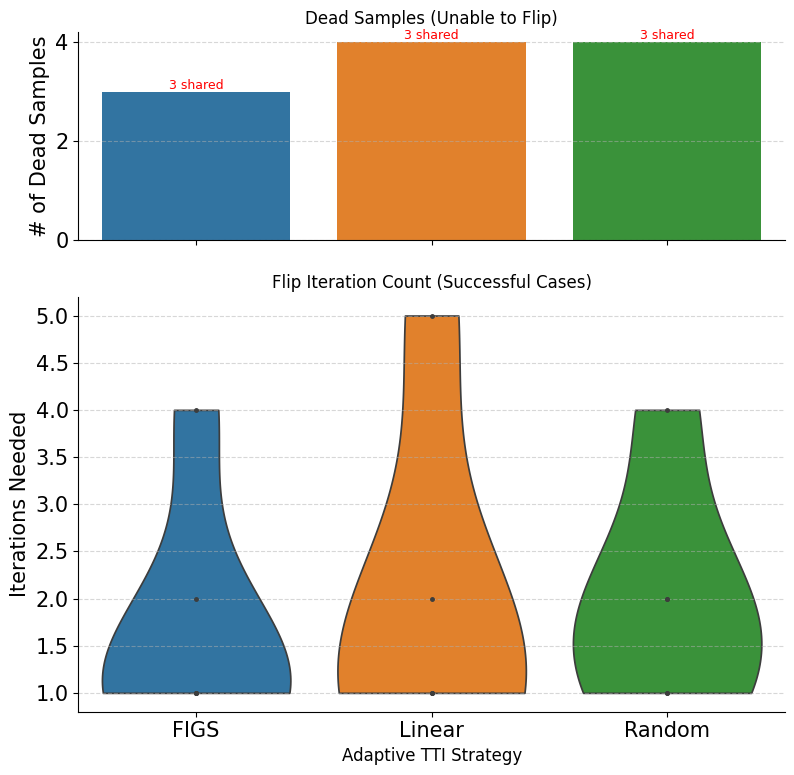

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data
nlp_dataset_flip_cnt = {
    'adap': [31, 1, 31, 31, 1, 1, 1, 2, 4],
    'rand': [31, 2, 31, 31, 1, 1, 31, 2, 4],
    'linear': [31, 1, 31, 31, 1, 1, 31, 2, 5]
}

# Convert to long-form DataFrame
records = []
for method, vals in nlp_dataset_flip_cnt.items():
    for i, v in enumerate(vals):
        records.append({
            'Sample ID': i,
            'Method': method,
            'Flip Count': v,
            'Dead': v == 31
        })
df = pd.DataFrame(records)

# Dead sample summary
dead_counts = df[df['Dead']].groupby('Method').size().reset_index(name='Dead Samples')

# Updated color palette and method labels
method_rename = {'adap': 'FIGS', 'rand': 'Random', 'linear': 'Linear'}
df['Method'] = df['Method'].map(method_rename)
dead_counts['Method'] = dead_counts['Method'].map(method_rename)

# Consistent color palette (blue: FIGS, orange: Linear, green: Random)
palette = {
    'FIGS': '#1f77b4',   # blue
    'Linear': '#ff7f0e',   # orange
    'Random': '#2ca02c'  # green
}

# Find samples that are dead across all methods
dead_per_sample = df[df['Dead']].groupby('Sample ID')['Method'].count()
common_dead_samples = dead_per_sample[dead_per_sample == 3].index.tolist()

# Update shared dead sample tagging after renaming
df['Shared Dead'] = df['Sample ID'].isin(common_dead_samples) & df['Dead']

# Regenerate plot with all requested fixes
fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

# Top: Dead sample counts
sns.barplot(x='Method', y='Dead Samples', data=dead_counts, ax=axs[0], palette=palette)
axs[0].set_title('Dead Samples (Unable to Flip)', fontsize=12)
axs[0].set_ylabel('# of Dead Samples')
axs[0].set_xlabel('')
axs[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Annotate shared dead counts
for index, row in dead_counts.iterrows():
    method = row['Method']
    shared_count = df[(df['Method'] == method) & (df['Shared Dead'])].shape[0]
    axs[0].text(index, row['Dead Samples'], f'{shared_count} shared', ha='center', va='bottom', fontsize=9, color='red')

# Bottom: Flip count distribution for successful interventions
sns.violinplot(
    x='Method',
    y='Flip Count',
    data=df[df['Flip Count'] != 31],  # exclude dead samples
    ax=axs[1],
    palette=palette,
    inner='point',
    cut=0
)
axs[1].set_title('Flip Iteration Count (Successful Cases)', fontsize=12)
axs[1].set_ylabel('Iterations Needed')
axs[1].set_xlabel('Adaptive TTI Strategy', fontsize=12)
axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.show()

plt.savefig('NLP_ATTI_flip_results.pdf', bbox_inches='tight')

/tmp/ipykernel_1918793/1573037207.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Dead Samples', data=dead_counts, ax=axs[0], palette=palette, order=method_order)
/tmp/ipykernel_1918793/1573037207.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


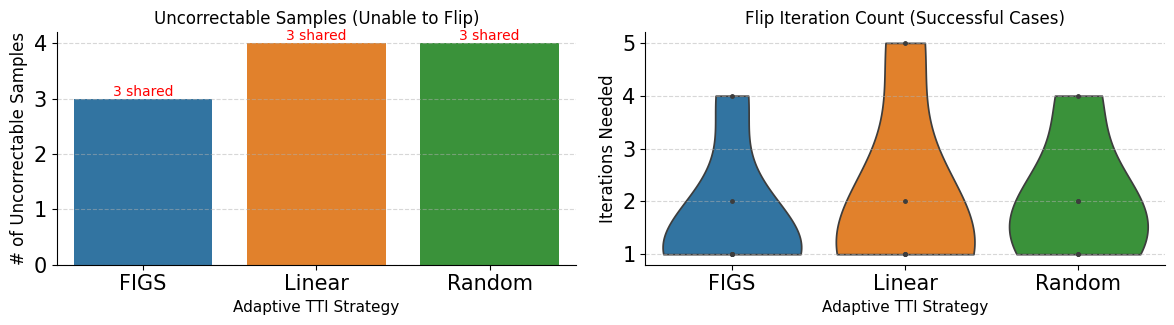

In [9]:
# Create side-by-side subplots
#fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)

# Set fixed method order
method_order = ['FIGS', 'Linear', 'Random']

# Left plot: Dead sample counts
sns.barplot(x='Method', y='Dead Samples', data=dead_counts, ax=axs[0], palette=palette, order=method_order)
axs[0].set_title('Uncorrectable Samples (Unable to Flip)', fontsize=12)
axs[0].set_ylabel('# of Uncorrectable Samples', fontsize=12)
axs[0].set_xlabel('Adaptive TTI Strategy', fontsize=11)
axs[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Annotate shared dead sample counts
for index, row in dead_counts.iterrows():
    method = row['Method']
    shared_count = df[(df['Method'] == method) & (df['Shared Dead'])].shape[0]
    axs[0].text(index, row['Dead Samples'], f'{shared_count} shared', ha='center', va='bottom', fontsize=10, color='red')

# Right plot: Flip count distribution for successful interventions
sns.violinplot(
    x='Method',
    y='Flip Count',
    data=df[df['Flip Count'] != 31],
    ax=axs[1],
    palette=palette,
    inner='point',
    cut=0,
    order=method_order
)
axs[1].set_title('Flip Iteration Count (Successful Cases)', fontsize=12)
axs[1].set_ylabel('Iterations Needed', fontsize=12)
axs[1].set_xlabel('Adaptive TTI Strategy', fontsize=11)
axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.show()
plt.savefig('NLP_ATTI_flip_results_wide.pdf', bbox_inches='tight')

# Baselines

In [66]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import imodelsx.process_results
import sys
from sklearn.metrics import accuracy_score
import imodelsx

sys.path.append('../experiments/')
results = []

results_dir = '../results/distillation_tbm_baseline/agnews'

# load the results in to a pandas dataframe
baseline_r = imodelsx.process_results.get_results_df(results_dir)

100%|██████████| 20/20 [00:00<00:00, 535.84it/s]


In [70]:
baseline_r[baseline_r['teacher_name'] == 'linear'][['student_name', 'max_depth', 'student_prediction_test_accuracy']]

,student_name,max_depth,student_prediction_test_accuracy
3,DecisionTreeRegressor,3,0.812
4,DecisionTreeRegressor,2,0.660
7,XGBRegressor,3,0.868
10,RandomForestRegressor,3,0.828
12,RandomForestRegressor,2,0.784


In [55]:
baseline_r.columns

Index(['save_dir', 'teacher_path', 'train_path', 'task_type', 'task_name',
       'teacher_name', 'student_name', 'do_intervention', 'n_trees_list',
       'n_rules_list', 'n_depth_list', 'min_impurity_decrease_list',
       'max_rules', 'max_trees', 'max_depth', 'metric',
       'num_interactions_intervention', 'use_cache', 'save_dir_unique',
       'student_distillation_train_r2', 'student_distillation_test_r2',
       'student_prediction_train_r2', 'student_prediction_test_r2',
       'teacher_prediction_train_r2', 'teacher_prediction_test_r2'],
      dtype='object')